# Training Notebook

### Notes:
- 4 models are built in this notebook. Most of these have at least 2 additions / changes from the previous one. This makes it a little unclear as to the positive/negative effect of a single change. This is done as fitting a new model per change would be too time-consuming to display here.
- Some of the patience values for EarlyStopping have been reduced, and the learning rates increased. This is to speed up time to fit a model for display in this notebook, for the most precise model possible these would be changed.
- ResNet50 was used as the base model for all models built. While it would be useful to try other base models, I felt simply substituting the base was less interesting than experimenting with data augmentation, freezing/unfreezing layers and adjusting hyperparameters. Therefore I left it out of this notebook, but I acknowledge it would be useful for a project with less time constraints.

I ran this notebook in xm xs on my laptop (no GPU).

### Dataset

We are using images of shoes from various brands, namely:

- Adidas
- Nike
- Onitsuka

While the shoe brands have some stylistic differences, they overlap a lot in terms of colour, silhouette and materials. The main distinguishing factor is the logo, be that the Adidas 3 stripes, the Nike swoosh or the Onitsuka stripes. This is what our model will likely try to identify as it learns.

In [1]:
# magic commands
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Input, Sequential, Model
from tensorflow.keras.layers import Lambda, Layer, Flatten, Dense, RandomFlip, RandomRotation, RandomZoom, RandomTranslation, BatchNormalization, Rescaling, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.python.keras.utils.layer_utils import count_params

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# get paths of image folders
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

In [4]:
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="categorical", image_size=(224, 224), color_mode="rgb")
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="categorical", image_size=(224, 224), color_mode="rgb")
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="categorical", image_size=(224, 224), color_mode="rgb")

Found 150 files belonging to 3 classes.
Found 75 files belonging to 3 classes.
Found 75 files belonging to 3 classes.


## Model 1 - Basic ResNet50 Model

We will begin by using ResNet50 to create a basic transfer learning model. We will use no data augmentation or other techniques, but will simply replace the default imagenet output layer with one for our 3 classes. This will give us a simple model that we can use as a baseline.

In [5]:
# initialise resnet, freezing layers
resnet50_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
resnet50_base.trainable = False

In [6]:
# create model
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = resnet50_base(x)
x = Flatten()(x)
outputs = Dense(3, activation="softmax")(x)
model_1 = Model(inputs=inputs, outputs=outputs)

In [7]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 3)                 301059

We take the output from the ResNet50 with imagenet weights, flatten them, and feed them into a dense layer with 3 nodes (as we have 3 classes)

In [8]:
# compile model
model_1.compile(optimizer=RMSprop(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])

In [9]:
# train model
model_1_history = model_1.fit(train_dataset, epochs=30,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
                verbose=0)

We will visualise our loss and accuracy for the training and validation set as we trained the model

<Axes: >

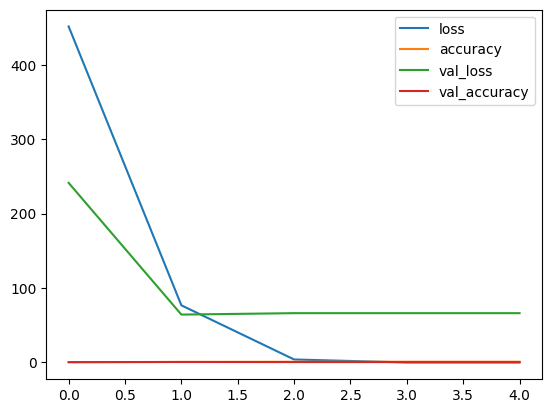

In [10]:
pd.DataFrame(model_1_history.history).plot()

We can see that the loss dropped, but as it plateaued there was a gap between the training and validation loss, suggesting overfitting. There are a few ways we can try to remedy this, which we will try in the next model. These are:

- adding dropout layers
- data augmentation

## Model 2 - Aiming to reduce overfitting

We will try to build on the first model, reducing overfitting that was observed. Overfitting can happen if our dataset is too small, or the model complexity is too high (proportionately to the dataset size). We will try to increase our dataset size by using data augmentation, and will introduce dropout layers to remove unnecessary connections in our network.

These step should produce a model that doesn't overfit as much.

### Data Augmentation

Below we will define some augmentation layers, which we will use in our model to make the dataset more diverse. This should enable it to generalise better.
The following augmentation layers are taken from lecture 22 of AI 1.

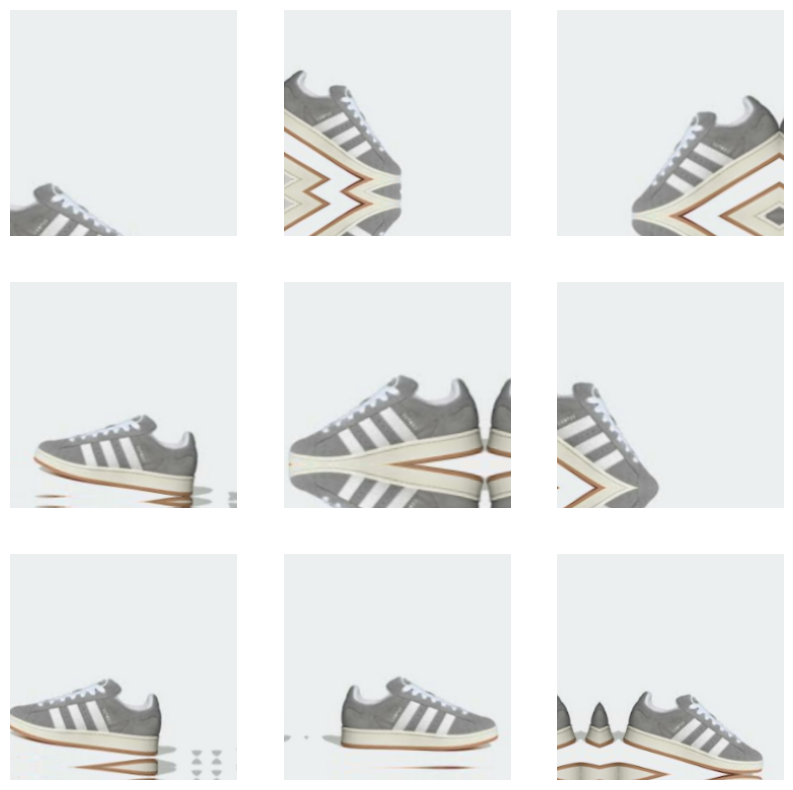

In [11]:
augmentation_layers = Sequential([
   Input(shape=(224, 224, 3)),
   RandomFlip(mode="horizontal"),
   RandomRotation(factor=0.1),
   RandomZoom(height_factor=(-0.2, 0.2)),
   RandomTranslation(height_factor=0.2, width_factor=0.2)
])

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = augmentation_layers(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Custom Keras Layer

Looking at these images, they clearly give a more diverse set of images. However, we could make the data more diverse by changing the colour of the image. The colours of the shoe and any other details are not really useful for identifying the brand, and we don't want to wrongly infer this in our network.

We will create a custom keras layer to apply a colour filter to our image. Keras layers can be defined as a class and need to include specific methods. Information on how to create a custom Keras layer was found at [this link](https://www.tutorialspoint.com/keras/keras_customized_layer.htm)

In [12]:
# define our new layer, inheriting from the keras Layer class
class ColourFilterLayer(Layer):
    # initialise with the superclass, adding the colour filter param (3 random values between 0 and 1)
    def __init__(self, **kwargs):
        super(ColourFilterLayer, self).__init__(**kwargs)
        self.colour_filter = [random.uniform(0,1), random.uniform(0,1), random.uniform(0,1)]

    # inherit build method from Layer class
    def build(self, input_shape):
        super(ColourFilterLayer, self).build(input_shape)

    # apply the colour filter to each channel (rgb) when called
    def call(self, inputs, **kwargs):
        return inputs * self.colour_filter

    # required method
    def compute_output_shape(self, input_shape):
        return input_shape

We will create our augmentation layer again, adding in the ColourFilterLayer, and see how this looks.

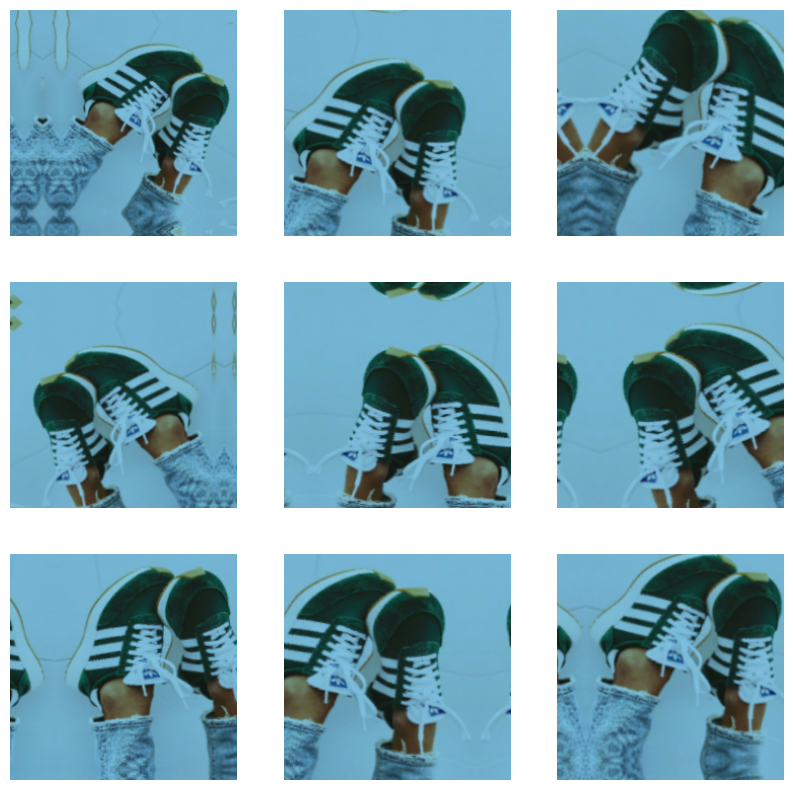

In [13]:
augmentation_layers = Sequential([
   Input(shape=(224, 224, 3)),
   RandomFlip(mode="horizontal"),
   RandomRotation(factor=0.1),
   RandomZoom(height_factor=(-0.2, 0.2)),
   RandomTranslation(height_factor=0.2, width_factor=0.2),
   ColourFilterLayer()
])

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = augmentation_layers(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

While a single augmented example may be less realistic than the original image, using this approach will expose our model to a much more diverse set of data.

In [14]:
# create model
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = augmentation_layers(x)
x = resnet50_base(x)

# adding dropout layer to simplify model
x = Dropout(0.2)(x)

x = Flatten()(x)
outputs = Dense(3, activation="softmax")(x)
model_2 = Model(inputs=inputs, outputs=outputs)

In [15]:
# compile model
model_2.compile(optimizer=RMSprop(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])

We will increase the number of epochs, as we are using augmented data each iteration so it should continue to learn for longer

In [16]:
# train model (running for more epochs)
model_2_history = model_2.fit(train_dataset, epochs=60,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
                verbose=0)

<Axes: >

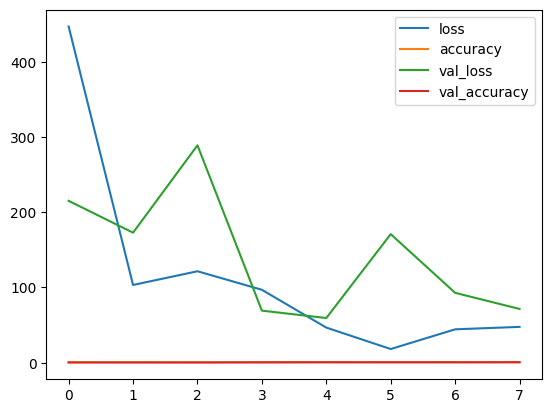

In [17]:
pd.DataFrame(model_2_history.history).plot()

As we can see from the graph, there is still a gap between our validation and training loss. This might be because our base model is too specific. The imagenet weights with the ResNet50 architecture are trained to identify 1,000 classes, for classes such as isopod, ibex, and police van. While we aren't using the top output layer, this model is still very specific. In our dataset, we are essentially trying to identify the brand symbols on the shoes, so we might benefit from using the deeper, more abstract layers.

We will unfreeze and train some of the top layers on our base model, in the hopes that it can become better suited to our use case.

## Model 3 - Unfreezing base model

In [18]:
# examine our resnet base model layers
resnet50_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [19]:
len(resnet50_base.layers)

175

The ResNet model has 175 layers, with over 23 million parameters. We don't want to undo the learning of the model by making all of these parameters trainable, so we will unfreeze the top 50 layers and review how many parameters will be trainable.

In [20]:
for layer in resnet50_base.layers[-30:]:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [21]:
# create model
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = augmentation_layers(x)
x = resnet50_base(x)

# adding dropout layer to simplify model
x = Dropout(0.2)(x)

x = Flatten()(x)
outputs = Dense(3, activation="softmax")(x)
model_3 = Model(inputs=inputs, outputs=outputs)

In [22]:
# compile model
model_3.compile(optimizer=RMSprop(learning_rate=0.01), loss="categorical_crossentropy", metrics=["accuracy"])

In [23]:
# train model
model_3_history = model_3.fit(train_dataset, epochs=60,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
                verbose=0)

<Axes: >

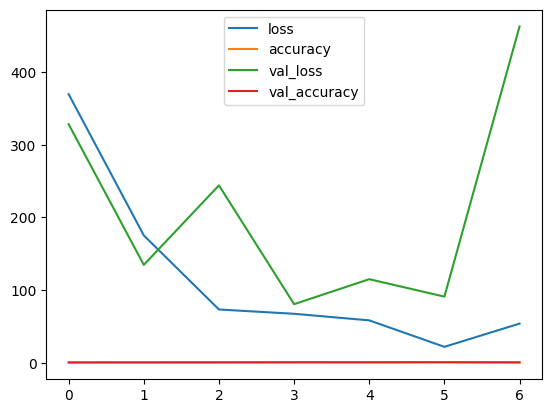

In [24]:
pd.DataFrame(model_3_history.history).plot()

The validation loss is much lower than our previous models. This is the most promising model so far.

## Model 4 - improve on previous model

Unfreezing the base model's upper layers appears to have given good results. We will now try to improve this model by increasing a few metrics, that may improve its performance. These metrics are:

- number of layers unfroze from base model. This will mean we have more trainable parameters, and our model will learn from the more abstract shapes identified in the deeper layers, to hopefully fine-tune better.
- patience in EarlyStopping callback. Increasing the number of epochs we are willing to continue training without observing an improvement in our target metric (val_loss), will potentially allow us to escape local minima and reach better results, although it will take longer to train.
- reduce the learning rate. This will mean we will approach the reduction of our loss function at a lower speed, which will take longer but can give us a more precise model.

In [25]:
# unfreezing top 60 layers, ~1/3 of the base model
for layer in resnet50_base.layers[-60:]:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [26]:
# create model
inputs = Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = augmentation_layers(x)
x = resnet50_base(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
outputs = Dense(3, activation="softmax")(x)
model_4 = Model(inputs=inputs, outputs=outputs)

In [27]:
# compile model with reduced learning rate
model_4.compile(optimizer=RMSprop(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [28]:
# train model with higher patience value
model_4_history = model_4.fit(train_dataset, epochs=60,
                validation_data=val_dataset,
                callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
                verbose=0)

<Axes: >

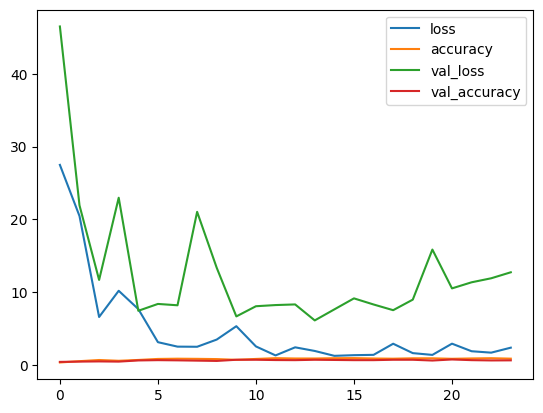

In [29]:
pd.DataFrame(model_4_history.history).plot()

# Evaluation of Model Performance

We will now evaluate our models, to identify which model is the most accurate (which we will consider the best).

In [30]:
# Model 1
model_1_loss, model_1_acc = model_1.evaluate(test_dataset)
model_1_acc, model_1_loss

3/3 [==============================] - 4s 1s/step - loss: 27.2332 - accuracy: 0.7467


(0.746666669845581, 27.233217239379883)

In [31]:
# Model 2
model_2_loss, model_2_acc = model_2.evaluate(test_dataset)
model_2_acc, model_2_loss

3/3 [==============================] - 5s 1s/step - loss: 32.7870 - accuracy: 0.7867


(0.7866666913032532, 32.78703308105469)

In [ ]:
# Model 3 
model_3_loss, model_3_acc = model_3.evaluate(test_dataset)
model_3_acc, model_3_loss

1/3 [=========>....................] - ETA: 4s - loss: 72.7393 - accuracy: 0.5625

In [ ]:
# Model 4 
model_4_loss, model_4_acc = model_4.evaluate(test_dataset)
model_4_acc, model_4_loss

In [ ]:
fig = plt.figure(figsize = (10, 5))

ax = plt.gca()
ax.set_ylim([0, 1])
 
plt.bar(["Model 1", "Model 2", "Model 3", "Model 4"], [model_1_acc, model_2_acc, model_3_acc, model_4_acc], color ='maroon', 
        width = 0.4)
 
plt.xlabel("model")
plt.ylabel("accuracy")
plt.title("Model Accuracy Comparison")
plt.show()

In [ ]:
fig = plt.figure(figsize = (10, 5))
plt.bar(["Model 1", "Model 2", "Model 3", "Model 4"], [model_1_loss, model_2_loss, model_3_loss, model_4_loss], color ='green', 
        width = 0.4)
plt.xlabel("model")
plt.ylabel("loss")
plt.title("Model Loss Comparison")
plt.show()

### Analysis

**NOTE:** The accuracy of the models may vary each time it is run, the following accuracies were observed for me, and analysis / observations are based on these results

| Model | Accuracy (%) | Loss |
| --- | --- | --- |
| 1 | 77.33 | 34.90 |
| 2 | 78.67 | 22.08 |
| 3 | 74.67 | 3.80 |
| 4 | 78.67 | 0.70 | 

As we can see, the accuracy is very similar between models. There is 75 examples in our test dataset, so the accuracy range from our most to least accurate model represents a difference of 3 examples - 59 correct for the best and 56 correct for the best.

A notable difference between the models, however, is the loss. Model 4 has by far the lowest loss score, indicating that it was more confident about its correct answers, and aware when it was uncertain. As Model 4 also has the joint highest accuracy score, we will take it as our best model.


In [ ]:
# save our best model
model_4.save("best_network.h5")